# Evaluation and Analysis
- Apply 4 or more performance metrics to analyze the results
- Include 3 or more visualization techniques for presenting the results
- Compare and analyze all the ML models that you have built for the project and present the performance analysis

## Setup

In [1]:
# Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy
import matplotlib.pyplot as plot
import seaborn as sns
import pandas
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

# Load preprocessed data
data = pandas.read_csv('augmented_data.csv')
print("Dataset read.")

# Input features and target
x = data[[ 	'latitude', 'longitude', # Location
		  	'year', 'month', 'day', 'hour', # Time; Removing 'minute' increased scores slightly
			'nst', 'gap', 'dmin',
			'rms', 'horizontalError', 'depthError', 'magNst' # Quality
		]]
y = data[ 'mag' ]
print("Features saved.")

# Split inot training and testing datasets
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.2, random_state = 42 )
print("Data split.")

real_xtest = xtest[ ytest > 0 ]
real_ytest = ytest[ ytest > 0 ]

Dataset read.
Features saved.
Data split.


## ML Models

In [2]:
# Linear
linear = LinearRegression()
linear.fit( xtrain, ytrain )

with open('linear.model', 'wb') as f:
	pickle.dump( linear, f )

linear_model = pickle.load( open('linear.model', 'rb') )
score_linear = linear_model.score( xtest, ytest )
print("Linear model score:", score_linear )

Linear model score: 0.06552262168577538


In [3]:
# Decision Tree
decision_tree = DecisionTreeRegressor( random_state = 42 )
decision_tree.fit( xtrain, ytrain )

with open('decision_tree.model', 'wb') as f:
	pickle.dump( decision_tree, f )

decision_tree_model = pickle.load( open('decision_tree.model', 'rb') )
score_dt = decision_tree_model.score( xtest, ytest )
print("Decision tree model score:", score_dt )

Decision tree model score: -0.05212163903138589


In [2]:
# Random Forest
random_forest = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42 )
random_forest.fit( xtrain, ytrain )

with open('random_forest.model', 'wb') as f:
	pickle.dump( random_forest, f )

random_forest_model = pickle.load( open('random_forest.model', 'rb') )
score_rf = random_forest_model.score( xtest, ytest )
real_score_rf = random_forest_model.score( real_xtest, real_ytest )
print("Real test score:", real_score_rf )
print("Random forest model score:", score_rf )

Real test score: 0.48286471385663143
Random forest model score: 0.9479716151734912


In [5]:
# Gradient Boosting
gradient_regression = HistGradientBoostingRegressor( max_iter = 200, random_state=42 )
gradient_regression.fit( xtrain, ytrain)

with open('gradient_regression.model', 'wb') as f:
	pickle.dump( gradient_regression, f )

gradient_regression_model = pickle.load( open('gradient_regression.model', 'rb') )
score_gb = gradient_regression_model.score( xtest, ytest )
print("Gradient regression model score:", score_gb )

Gradient regression model score: 0.43206115878759843


In [6]:
# Bagging
bagging_regression = BaggingRegressor( n_estimators=100, n_jobs = -1, random_state=42 )
bagging_regression.fit( xtrain, ytrain)

with open('bagging_regression.model', 'wb') as f:
    pickle.dump ( bagging_regression, f)

bagging_regression_model = pickle.load( open('bagging_regression.model', 'rb') )
score_bag = bagging_regression_model.score( xtest, ytest )
print("Bagging Regression model score:", score_bag )

Bagging Regression model score: 0.45917831395013287


In [7]:
# XGBoost
xgb = XGBRegressor(
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    n_jobs = -1,
    random_state = 42
)
xgb.fit( xtrain, ytrain )

with open('xgboost.model', 'wb') as f:
    pickle.dump( xgb, f )

xgb_model = pickle.load( open( 'xgboost.model', 'rb' ))
score_xgb = xgb_model.score( xtest, ytest )
print("XGBoost model score:", score_xgb )

XGBoost model score: 0.412589720125651


## Evaluation

,R²,MAE,MSE,RMSE,MAPE
Linear,0.0655,0.2827,0.1403,0.3746,0.0938
Decision Tree,-0.0521,0.2794,0.1580,0.3974,0.0939
Random Forest,0.4599,0.2084,0.0811,0.2848,0.0699
Gradient Boosting,0.4321,0.2156,0.0853,0.2920,0.0719
Bagging,0.4592,0.2087,0.0812,0.2849,0.0700
XGBoost,0.4126,0.2203,0.0882,0.2970,0.0736


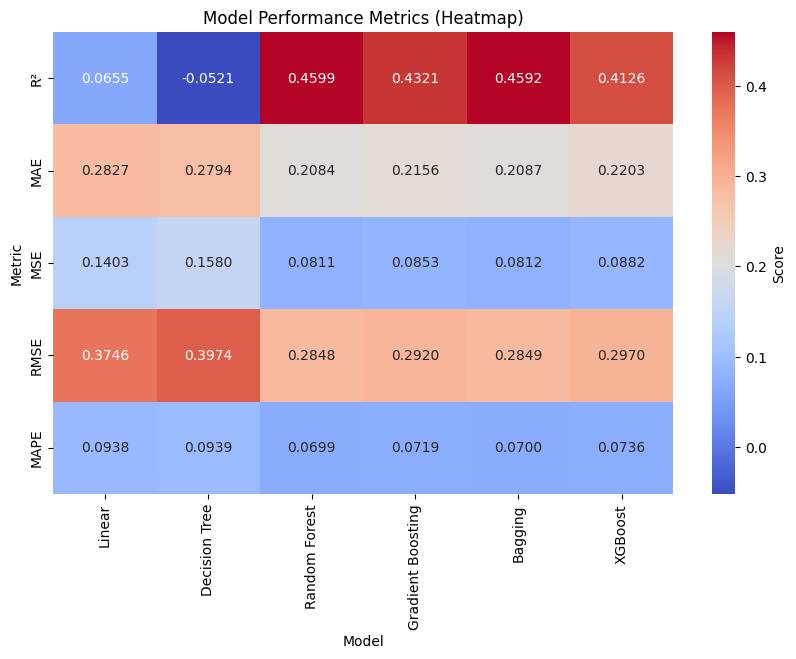

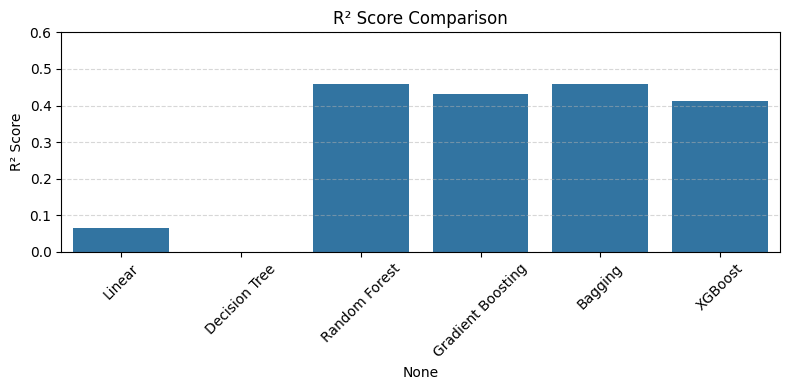

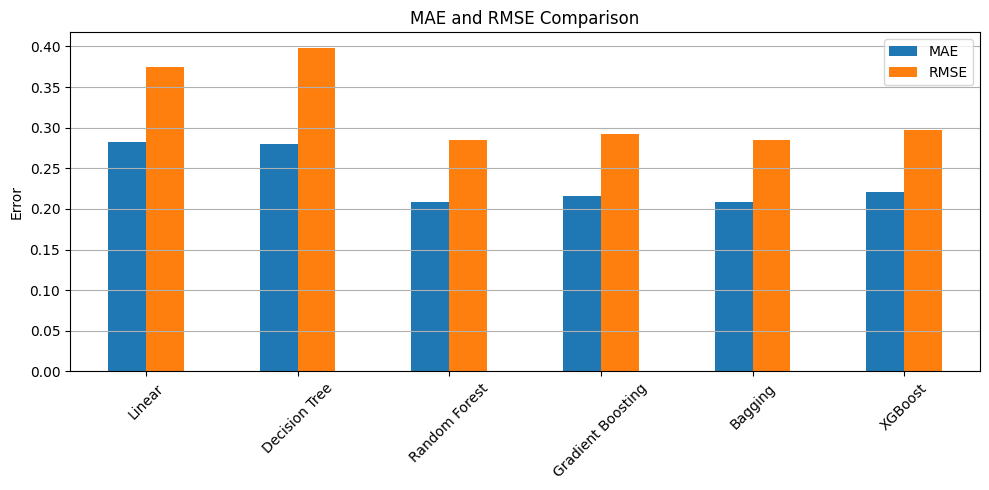

In [12]:
# Store predictions for comparison
models = {
    "Linear": linear_model,
    "Decision Tree": decision_tree_model,
    "Random Forest": random_forest_model,
    "Gradient Boosting": gradient_regression_model,
    "Bagging": bagging_regression_model,
    "XGBoost": xgb_model
}

metrics = {
    "R²": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "MAPE": []
}

for name, model in models.items():
    y_pred = model.predict(xtest)
    metrics["R²"].append(r2_score(ytest, y_pred))
    metrics["MAE"].append(mean_absolute_error(ytest, y_pred))
    metrics["MSE"].append(mean_squared_error(ytest, y_pred))
    metrics["RMSE"].append(numpy.sqrt(mean_squared_error(ytest, y_pred)))
    metrics["MAPE"].append(mean_absolute_percentage_error(ytest, y_pred))

results_df = pandas.DataFrame(metrics, index=models.keys())
results_df = results_df.round(4)
display(results_df)

# 1. Heatmap of all metrics
plot.figure(figsize=(10, 6))
sns.heatmap(results_df.T, annot=True, cmap="coolwarm", fmt=".4f", cbar_kws={"label": "Score"})
plot.title("Model Performance Metrics (Heatmap)")
plot.ylabel("Metric")
plot.xlabel("Model")
plot.show()

# 2. Bar plot of R² scores
plot.figure(figsize=(8, 4))
sns.barplot(x=results_df.index, y=results_df["R²"])
plot.title("R² Score Comparison")
plot.ylabel("R² Score")
plot.ylim(0, 0.6)
plot.grid( axis = 'y', linestyle = '--', alpha = 0.5 )
plot.xticks(rotation=45)
plot.tight_layout()
plot.show()

# 3. Side-by-side bar plot for MAE and RMSE
mae_rmse_df = results_df[["MAE", "RMSE"]].copy()
mae_rmse_df.plot(kind="bar", figsize=(10, 5))
plot.title("MAE and RMSE Comparison")
plot.ylabel("Error")
plot.xticks(rotation=45)
plot.tight_layout()
plot.grid(axis='y')
plot.show()